In [1]:
### 1. IMPORT LIBRARIES

In [2]:

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
import missingno as msno
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import pickle


# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\igho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 2. LOAD DATASET

In [4]:
# Load dataset
data = pd.read_csv(r"C:\Users\igho\Desktop\10\My Github\Customer Sentiment Analysis\data\Sentiment dataset.csv")

# Make a copy of the dataset
data1 = data.copy()

### 3. DATA OVERVIEW

In [6]:
# Overview of the dataset
data.info()

# Check for missing values and drop them
#data.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Reviewer     11997 non-null  object
 1   Country      11997 non-null  object
 2   StarRatings  12000 non-null  int64 
 3   Subject      12000 non-null  object
 4   Review       11161 non-null  object
 5   Date_posted  12000 non-null  object
dtypes: int64(1), object(5)
memory usage: 562.6+ KB


### 4. DATA PREPROCESSING

In [8]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Data cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Apply preprocessing to the 'Review' column
data['clean_review'] = data['Review'].apply(clean_text)

### 5. SENTIMENT ANALYSIS (Using VADER Sentiment Analysis)

In [10]:
# Download necessary NLTK data
nltk.download('vader_lexicon')
from tqdm.notebook import tqdm
from textblob import TextBlob

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\igho\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
# Instantiate VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [12]:
# Create a new 'ID' column by mapping the index of the DataFrame to a zero-padded string (e.g., '01', '02', etc.).
data['ID'] = data.index.map(lambda x: f'{x:02}')

# Reorder the columns in the DataFrame so that the 'ID' column comes first, followed by the other columns.
data = data[['ID'] + [col for col in data.columns if col != 'ID']]
data.head()

,ID,Reviewer,Country,StarRatings,Subject,Review,Date_posted,clean_review
0,00,Mike Santarcangelo,US,3,"Amazon may be a fine company, but...","Amazon is easy to work with, but they fulfill ...","Tuesday, June 4, 2024",amazon easy work fulfill order via rd party co...
1,01,Arthur Riding,GB,5,"Great range of products, generally superior qu...",I have been using AliExpress for well over a y...,"Tuesday, June 4, 2024",using aliexpress well year consistently impres...
2,02,UK shopper Val,GB,5,Good!,"A good, customer-centric marketplace. But neve...","Monday, June 3, 2024",good customercentric marketplace nevertheless ...
3,03,Jim Corkery,CA,1,I purchased an Android Tesla style…,I purchased an Android Tesla style radio.\nAft...,"Sunday, June 2, 2024",purchased android tesla style radio installed ...
4,04,chris bardin,IE,1,They are an absolute con job dont waste…,They are an absolute con job dont waste your m...,"Tuesday, June 4, 2024",absolute con job dont waste money scammer rece...


In [13]:
# Run polarity score on the entire dataset
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['clean_review']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [14]:
# VADER Sentiment polarity score
vader_score = pd.DataFrame(res).T
vader_score.head()

,neg,neu,pos,compound
00,0.030,0.583,0.387,0.9432
01,0.000,0.694,0.306,0.9689
02,0.153,0.587,0.259,0.6705
03,0.000,0.909,0.091,0.5719
04,0.073,0.792,0.135,0.2575


In [15]:
# Merge VADER sentiment polarity score with original dataframe
vader_score = vader_score.reset_index().rename(columns={'index': 'ID'})
data = data.merge(vader_score, how='left')
data.head()

,ID,Reviewer,Country,StarRatings,Subject,Review,Date_posted,clean_review,neg,neu,pos,compound
0,00,Mike Santarcangelo,US,3,"Amazon may be a fine company, but...","Amazon is easy to work with, but they fulfill ...","Tuesday, June 4, 2024",amazon easy work fulfill order via rd party co...,0.030,0.583,0.387,0.9432
1,01,Arthur Riding,GB,5,"Great range of products, generally superior qu...",I have been using AliExpress for well over a y...,"Tuesday, June 4, 2024",using aliexpress well year consistently impres...,0.000,0.694,0.306,0.9689
2,02,UK shopper Val,GB,5,Good!,"A good, customer-centric marketplace. But neve...","Monday, June 3, 2024",good customercentric marketplace nevertheless ...,0.153,0.587,0.259,0.6705
3,03,Jim Corkery,CA,1,I purchased an Android Tesla style…,I purchased an Android Tesla style radio.\nAft...,"Sunday, June 2, 2024",purchased android tesla style radio installed ...,0.000,0.909,0.091,0.5719
4,04,chris bardin,IE,1,They are an absolute con job dont waste…,They are an absolute con job dont waste your m...,"Tuesday, June 4, 2024",absolute con job dont waste money scammer rece...,0.073,0.792,0.135,0.2575


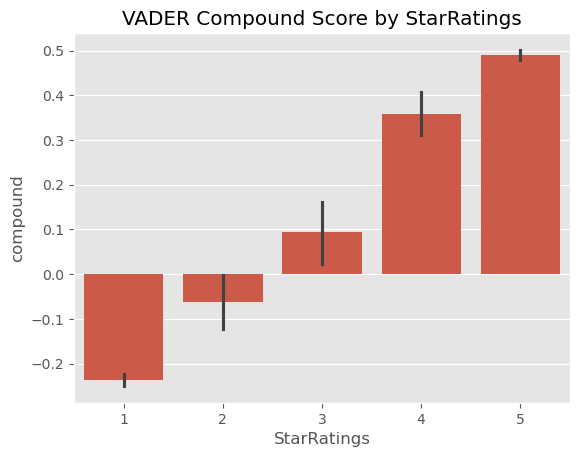

In [16]:
# Plot VADER Compound score and StarRatings
ax = sns.barplot(data=data, x='StarRatings', y='compound')
ax.set_title('VADER Compound Score by StarRatings')
plt.show()

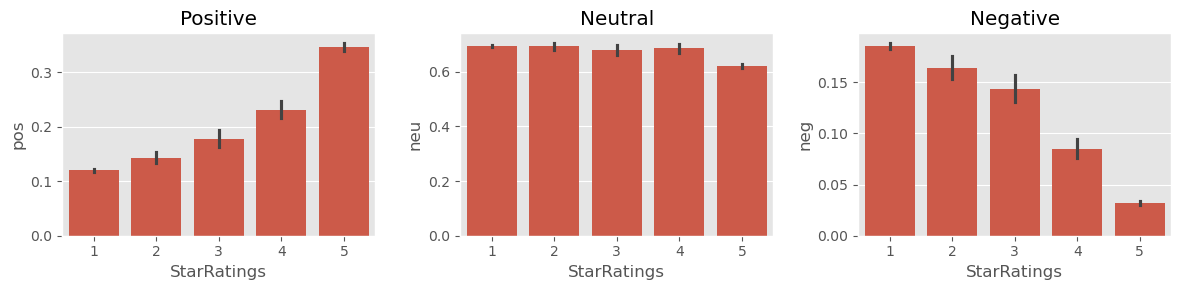

In [17]:
# Plot VADER Positive, Neutral and Negative scores and StarRatings
fig, axs = plt.subplots(1,3, figsize=(12,3))
sns.barplot(data=data, x='StarRatings', y='pos', ax=axs[0])
sns.barplot(data=data, x='StarRatings', y='neu', ax=axs[1])
sns.barplot(data=data, x='StarRatings', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [18]:
# Apply VADER sentiment analysis
data['vader_sentiment'] = data['clean_review'].apply(
    lambda x: 'positive' if sia.polarity_scores(x)['compound'] >= 0.05 else (
        'negative' if sia.polarity_scores(x)['compound'] <= -0.05 else 'neutral'))

# Filter out each sentiment from VADER sentiment analysis
positive_reviews = data[data['vader_sentiment'] == 'positive']['clean_review']
negative_reviews = data[data['vader_sentiment'] == 'negative']['clean_review']
neutral_reviews = data[data['vader_sentiment'] == 'neutral']['clean_review']

from collections import Counter

# Function to get the most common words
def get_most_common_words(reviews, n=50):
    all_words = ' '.join(reviews).split()
    return [word for word, count in Counter(all_words).most_common(n)]

# Get the top 50 most common words in positive, negative, and neutral reviews
positive_keywords = get_most_common_words(positive_reviews, 50)
negative_keywords = get_most_common_words(negative_reviews, 50)
neutral_keywords = get_most_common_words(neutral_reviews, 50)

print('Positive Keywords:', positive_keywords)
print('Negative Keywords:', negative_keywords)
print('Neutral Keywords:', neutral_keywords)

# Use these keywords to create the sentiment column
def determine_sentiment(text):
    text_tokens = word_tokenize(text)
    if any(word in text_tokens for word in positive_keywords):
        return 'positive'
    elif any(word in text_tokens for word in negative_keywords):
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create the sentiment column
data['vader_review_sentiment'] = data['clean_review'].apply(determine_sentiment)

Positive Keywords: ['aliexpress', 'good', 'seller', 'item', 'product', 'order', 'time', 'refund', 'get', 'service', 'customer', 'delivery', 'money', 'never', 'dont', 'received', 'quality', 'price', 'shipping', 'buy', 'day', 'great', 'ordered', 'one', 'return', 'amazon', 'even', 'like', 'back', 'company', 'would', 'fast', 'store', 'dispute', 'well', 'site', 'delivered', 'month', 'always', 'arrived', 'experience', 'tracking', 'use', 'help', 'sent', 'problem', 'review', 'ive', 'package', 'purchase']
Negative Keywords: ['aliexpress', 'item', 'seller', 'refund', 'order', 'money', 'customer', 'dispute', 'get', 'never', 'service', 'time', 'product', 'dont', 'back', 'received', 'return', 'ordered', 'even', 'company', 'one', 'buy', 'day', 'sent', 'would', 'delivered', 'delivery', 'month', 'package', 'good', 'tracking', 'send', 'scam', 'shipping', 'amazon', 'store', 'site', 'wrong', 'didnt', 'still', 'got', 'said', 'problem', 'pay', 'buyer', 'bought', 'use', 'bad', 'say', 'give']
Neutral Keyword

In [19]:
# Apply TextBlob sentiment analysis
data['textblob_sentiment'] = data['clean_review'].apply(
    lambda x: 'positive' if TextBlob(x).sentiment.polarity > 0 else (
        'negative' if TextBlob(x).sentiment.polarity < 0 else 'neutral'))

# Filter out each sentiment from TextBlob sentiment analysis
positive_reviews = data[data['textblob_sentiment'] == 'positive']['clean_review']
negative_reviews = data[data['textblob_sentiment'] == 'negative']['clean_review']
neutral_reviews = data[data['textblob_sentiment'] == 'neutral']['clean_review']

# Function to get the most common words
def get_most_common_words(reviews, n=50):
    all_words = ' '.join(reviews).split()
    return [word for word, count in Counter(all_words).most_common(n)]

# Get the top 50 most common words in positive, negative, and neutral reviews
positive_keywords = get_most_common_words(positive_reviews, 50)
negative_keywords = get_most_common_words(negative_reviews, 50)
neutral_keywords = get_most_common_words(neutral_reviews, 50)

print('Positive Keywords:', positive_keywords)
print('Negative Keywords:', negative_keywords)
print('Neutral Keywords:', neutral_keywords)

# Use these keywords to create the sentiment column
def determine_sentiment(text):
    text_tokens = word_tokenize(text)
    if any(word in text_tokens for word in positive_keywords):
        return 'positive'
    elif any(word in text_tokens for word in negative_keywords):
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create the sentiment column
data['textblob_review_sentiment'] = data['clean_review'].apply(determine_sentiment)

Positive Keywords: ['aliexpress', 'seller', 'item', 'good', 'product', 'order', 'refund', 'time', 'get', 'customer', 'service', 'money', 'delivery', 'never', 'dispute', 'received', 'dont', 'shipping', 'price', 'buy', 'day', 'one', 'quality', 'ordered', 'return', 'back', 'even', 'great', 'would', 'company', 'amazon', 'store', 'like', 'fast', 'many', 'delivered', 'problem', 'sent', 'site', 'month', 'package', 'also', 'tracking', 'use', 'arrived', 'thing', 'review', 'bought', 'year', 'always']
Negative Keywords: ['aliexpress', 'item', 'seller', 'refund', 'order', 'customer', 'service', 'money', 'get', 'never', 'time', 'product', 'dont', 'dispute', 'back', 'received', 'ordered', 'return', 'company', 'even', 'one', 'buy', 'day', 'sent', 'would', 'amazon', 'delivery', 'delivered', 'month', 'tracking', 'wrong', 'package', 'bad', 'send', 'site', 'like', 'shipping', 'still', 'store', 'said', 'contact', 'got', 'didnt', 'help', 'number', 'arrived', 'use', 'give', 'say', 'fake']
Neutral Keywords: 

In [20]:
# Define the sentiment function for 'StarRatings'
def star_rating_sentiment(StarRatings):
    if StarRatings == 1 or StarRatings == 2:
        return 'Negative'
    elif StarRatings == 4 or StarRatings == 5:
        return 'Positive'
    else:
        return 'Neutral'

data['StarRatings_sentiment'] = data['StarRatings'].apply(star_rating_sentiment)

In [21]:
# Evaluate TextBlob Model (Compare Textblob Sentiment with TextBlob Review Sentiment)
y_true = data['textblob_review_sentiment']
y_pred = data['textblob_sentiment']

labels = ['positive', 'neutral', 'negative']
textblob_confusion = confusion_matrix(y_true, y_pred, labels=labels)
textblob_accuracy = accuracy_score(y_true, y_pred)
textblob_f1 = f1_score(y_true, y_pred, average='weighted')
textblob_precision = precision_score(y_true, y_pred, average='weighted')
textblob_recall = recall_score(y_true, y_pred, average='weighted')

# Print the results
print('Textblob Confusion Matrix:')
print(textblob_confusion)
print('\nTextblob Accuracy Score:', textblob_accuracy)
print('Textblob F1 Score:', textblob_f1)
print('Textblob Precision Score:', textblob_precision)
print('Textblob Recall Score:', textblob_recall)

Textblob Confusion Matrix:
[[6269  997 3585]
 [ 189  915   20]
 [   9    8    8]]

Textblob Accuracy Score: 0.5993333333333334
Textblob F1 Score: 0.7109848240847106
Textblob Precision Score: 0.9212072309907217
Textblob Recall Score: 0.5993333333333334


In [22]:
# VADER Model Evaluation (Compare VADER Sentiment with VADER Review Sentiment)
y_true = data['vader_review_sentiment']
y_pred = data['vader_sentiment']

labels = ['positive', 'neutral', 'negative']
vader_confusion = confusion_matrix(y_true, y_pred, labels=labels)
vader_accuracy = accuracy_score(y_true, y_pred)
vader_f1 = f1_score(y_true, y_pred, average='weighted')
vader_precision = precision_score(y_true, y_pred, average='weighted')
vader_recall = recall_score(y_true, y_pred, average='weighted')

# Print the results
print('Vader Confusion Matrix:')
print(vader_confusion)
print('\nVader Accuracy Score:', vader_accuracy)
print('Vader F1 Score:', vader_f1)
print('Vader Precision Score:', vader_precision)
print('Vader Recall Score:', vader_recall)

Vader Confusion Matrix:
[[5620  647 4599]
 [ 180  902   16]
 [  10   13   13]]

Vader Accuracy Score: 0.5445833333333333
Vader F1 Score: 0.6723990277069185
Vader Precision Score: 0.9287345790595747
Vader Recall Score: 0.5445833333333333


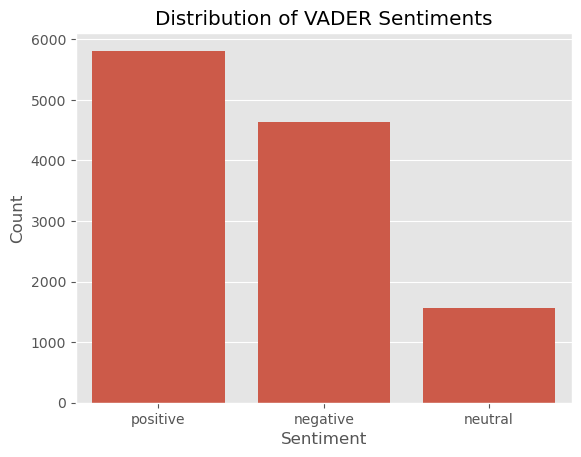

In [23]:
# Plot the distribution of sentiments
sns.countplot(x='vader_sentiment', data=data)
plt.title('Distribution of VADER Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

vader_sentiment
positive    48.42
negative    38.57
neutral     13.02
Name: count, dtype: float64


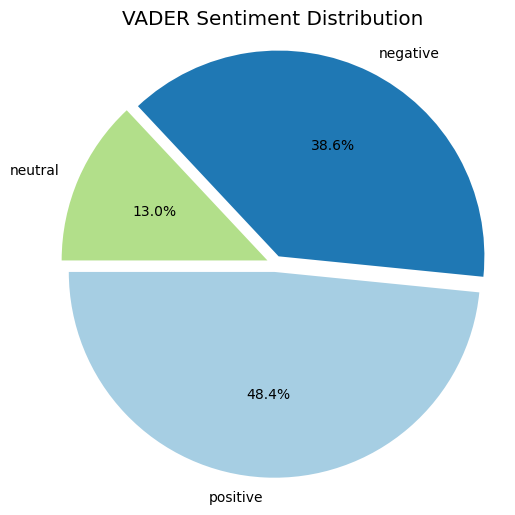

In [24]:
# Percentage Distribution of VADER Sentiment
vader_sentiment = round(data['vader_sentiment'].value_counts()/data.shape[0]*100,2)
print(vader_sentiment)

# Plot pie chart for the star ratings distribution
explode = [0.04] * len(vader_sentiment)
plt.figure(figsize=(6, 6))
plt.pie(vader_sentiment, labels=vader_sentiment.index, autopct='%1.1f%%', startangle=180, colors=plt.cm.Paired.colors, 
        explode=explode)
plt.title('VADER Sentiment Distribution')
plt.axis('equal')
plt.show()

In [25]:
# Count the occurrences of each sentiment in the 'vader_sentiment' column
vader_sentiment_counts = data['vader_sentiment'].value_counts()

# Count the occurrences of each sentiment in the 'sentiment' column
sentiment_counts = data['vader_review_sentiment'].value_counts()

# Create DataFrame for sentiment counts
sentiment_counts_data = pd.DataFrame({'VADER Sentiment': vader_sentiment_counts, 'Review Sentiment': sentiment_counts})

# Display the DataFrame
print("Sentiment Counts:")
print(sentiment_counts_data)

Sentiment Counts:
          VADER Sentiment  Review Sentiment
negative             4628                36
neutral              1562              1098
positive             5810             10866


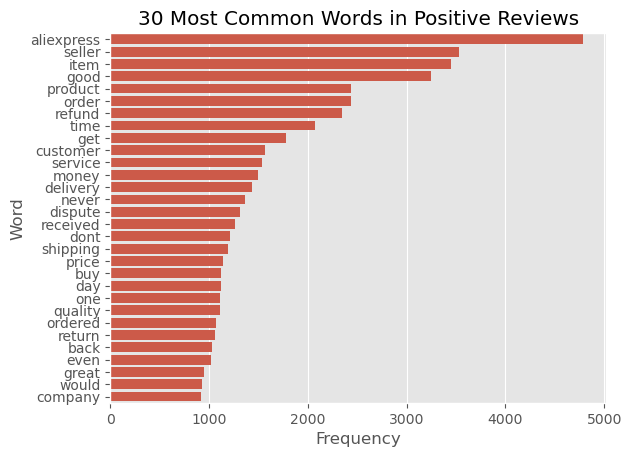

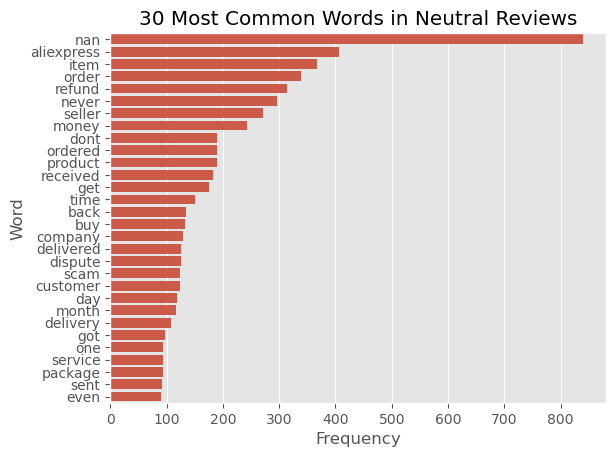

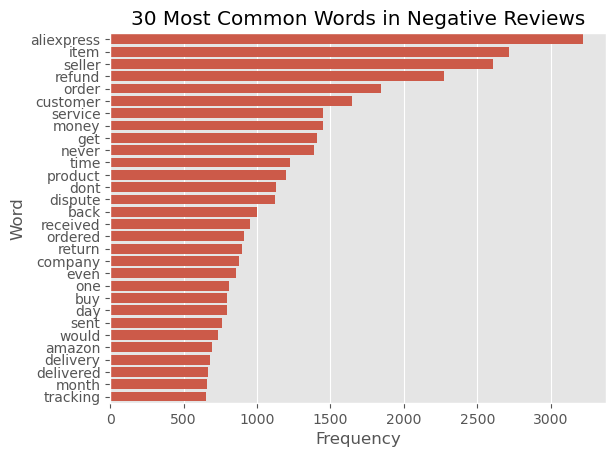

In [26]:
# Count most common words used in sentiments

# Get the most common words in positive reviews
positive_words = ' '.join(positive_reviews).split()
positive_word_freq = Counter(positive_words).most_common(30)

# Get the most common words in neutral reviews
neutral_words = ' '.join(neutral_reviews).split()
neutral_word_freq = Counter(neutral_words).most_common(30)

# Get the most common words in negative reviews
negative_words = ' '.join(negative_reviews).split()
negative_word_freq = Counter(negative_words).most_common(30)

# Plot the most common words in positive reviews
positive_df = pd.DataFrame(positive_word_freq, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=positive_df)
plt.title('30 Most Common Words in Positive Reviews')
plt.show()

# Plot the most common words in neutral reviews
neutral_df = pd.DataFrame(neutral_word_freq, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=neutral_df)
plt.title('30 Most Common Words in Neutral Reviews')
plt.show()

# Plot the most common words in negative reviews
negative_df = pd.DataFrame(negative_word_freq, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=negative_df)
plt.title('30 Most Common Words in Negative Reviews')
plt.show()

vader_review_sentiment
positive    10866
neutral      1098
negative       36
Name: count, dtype: int64


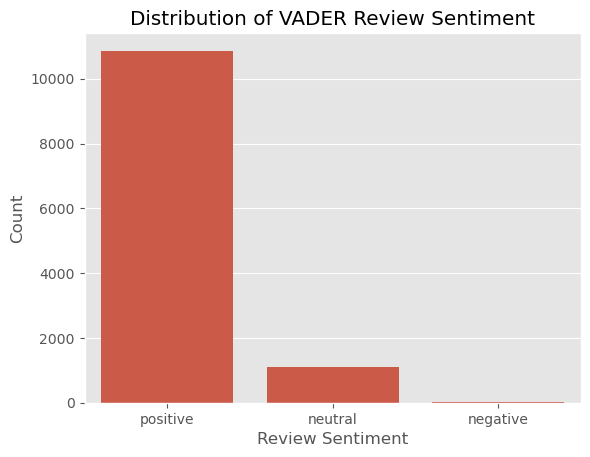

In [27]:
# Review Sentiment Distribution (VADER)
sentiment_count = data['vader_review_sentiment'].value_counts()
print(sentiment_count)

# Plot the distribution of sentiments
sns.countplot(x='vader_review_sentiment', data=data)
plt.title('Distribution of VADER Review Sentiment')
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
plt.show()

textblob_review_sentiment
positive    10851
neutral      1124
negative       25
Name: count, dtype: int64


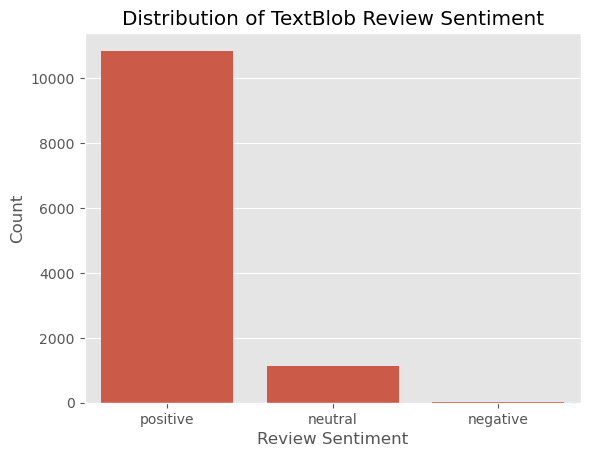

In [28]:
# Review Sentiment Distribution (TextBlob)
sentiment_count = data['textblob_review_sentiment'].value_counts()
print(sentiment_count)

# Plot the distribution of sentiments
sns.countplot(x='textblob_review_sentiment', data=data)
plt.title('Distribution of TextBlob Review Sentiment')
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
plt.show()

StarRatings_sentiment
Negative    6830
Positive    4890
Neutral      280
Name: count, dtype: int64


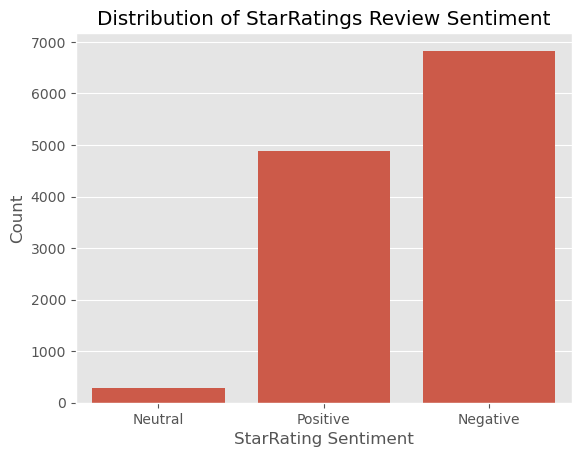

In [29]:
# Review Sentiment Distribution (StarRatings)
sentiment_count = data['StarRatings_sentiment'].value_counts()
print(sentiment_count)

# Plot the distribution of sentiments
sns.countplot(x='StarRatings_sentiment', data=data)
plt.title('Distribution of StarRatings Review Sentiment')
plt.xlabel('StarRating Sentiment')
plt.ylabel('Count')
plt.show()

vader_review_sentiment
positive    90.55
neutral      9.15
negative     0.30
Name: count, dtype: float64


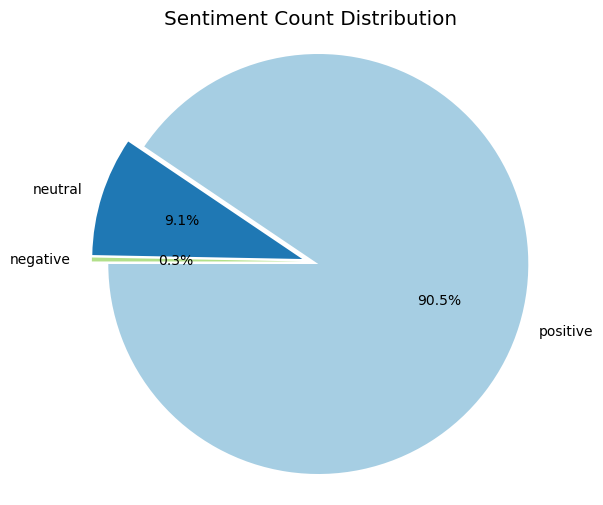

In [30]:
# Percentage Distribution of VADER review sentiment
sentiment_counts = round(data['vader_review_sentiment'].value_counts()/data.shape[0]*100,2)
print(sentiment_counts)

# Plot pie chart for the star ratings distribution
explode = [0.04] * len(sentiment_counts)
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=180, colors=plt.cm.Paired.colors, explode=explode)
plt.title('Sentiment Count Distribution')
plt.axis('equal')
plt.show()

Top 10 countries with Positive sentiment (VADER):
Country
GB    1078
US     893
CA     362
AU     287
NL     188
FR     179
BR     173
ES     160
NZ     156
IL     145
Name: count, dtype: int64


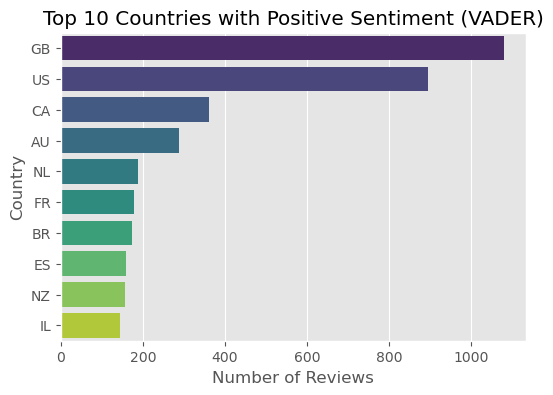

Top 10 countries with Positive sentiment (Review):
Country
GB    2664
US    1855
CA     719
AU     548
NL     331
ES     276
FR     272
NZ     266
IE     242
DE     230
Name: count, dtype: int64


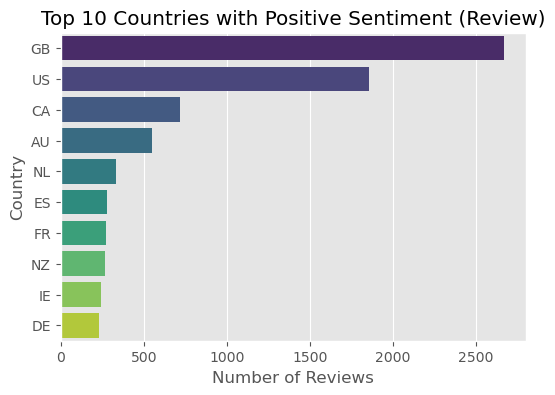

In [31]:
# Function to get top N countries by sentiment
def get_top_countries_by_sentiment(data, sentiment_column, sentiment_value, top_n=10):
    # Filter data by sentiment value
    sentiment_data = data[data[sentiment_column] == sentiment_value]
    
    # Count occurrences of each country
    country_counts = sentiment_data['Country'].value_counts().head(top_n)
    
    return country_counts

# Top 10 countries with Positive sentiment in 'vader_sentiment'

top_positive_countries_vader = get_top_countries_by_sentiment(data, 'vader_sentiment', 'positive')
print("Top 10 countries with Positive sentiment (VADER):")
print(top_positive_countries_vader)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_positive_countries_vader.values, y=top_positive_countries_vader.index, palette='viridis')
plt.title('Top 10 Countries with Positive Sentiment (VADER)')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.show()

# Top 10 countries with Positive sentiment in 'review_sentiment'

top_positive_countries_review = get_top_countries_by_sentiment(data, 'vader_review_sentiment', 'positive')
print("Top 10 countries with Positive sentiment (Review):")
print(top_positive_countries_review)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_positive_countries_review.values, y=top_positive_countries_review.index, palette='viridis')
plt.title('Top 10 Countries with Positive Sentiment (Review)')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.show()


Top 10 countries with Neutral sentiment (VADER):
Country
US    223
GB    205
NL     74
CA     70
ES     57
BR     54
AU     53
FR     43
IT     42
NZ     37
Name: count, dtype: int64


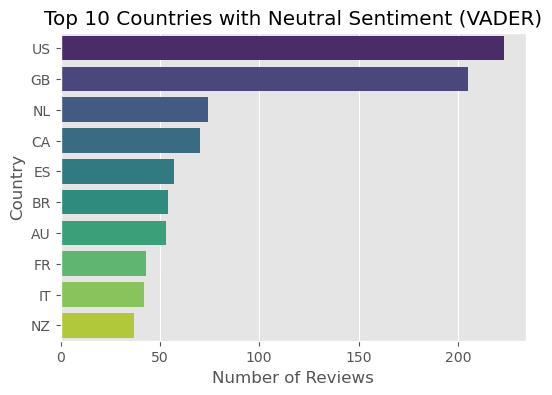


Top 10 countries with Neutral sentiment (Review):
Country
US    107
GB     60
NL     52
BR     52
CA     51
ES     43
IT     42
FR     39
AU     32
KR     31
Name: count, dtype: int64


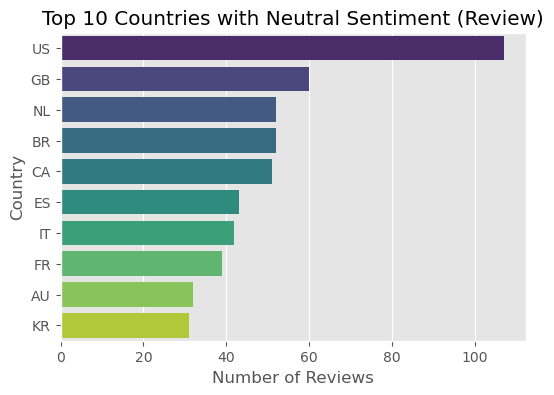

In [32]:
# Top 10 countries with Neutral sentiment in 'vader_sentiment'

top_neutral_countries_vader = get_top_countries_by_sentiment(data, 'vader_sentiment', 'neutral')
print("\nTop 10 countries with Neutral sentiment (VADER):")
print(top_neutral_countries_vader)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_neutral_countries_vader.values, y=top_neutral_countries_vader.index, palette='viridis')
plt.title('Top 10 Countries with Neutral Sentiment (VADER)')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.show()

# Top 10 countries with Neutral sentiment in 'review_sentiment'

top_neutral_countries_review = get_top_countries_by_sentiment(data, 'vader_review_sentiment', 'neutral')
print("\nTop 10 countries with Neutral sentiment (Review):")
print(top_neutral_countries_review)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_neutral_countries_review.values, y=top_neutral_countries_review.index, palette='viridis')
plt.title('Top 10 Countries with Neutral Sentiment (Review)')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.show()


Top 10 countries with Negative sentiment (VADER):
Country
GB    1450
US     851
CA     338
AU     242
NL     124
IE     110
ES     103
DK     101
NZ      97
FR      89
Name: count, dtype: int64


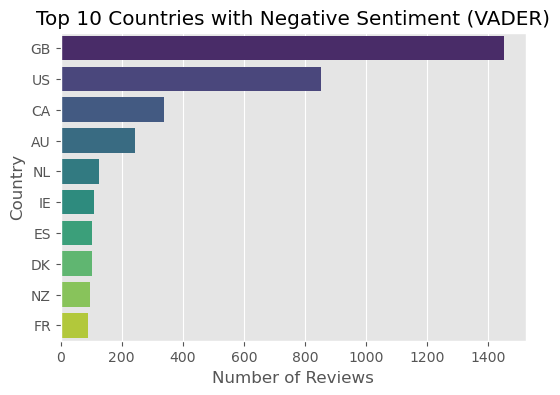


Top 10 countries with Negative sentiment (Review):
Country
GB    9
US    5
NL    3
NO    2
EE    2
SK    2
AU    2
IT    1
NZ    1
RU    1
Name: count, dtype: int64


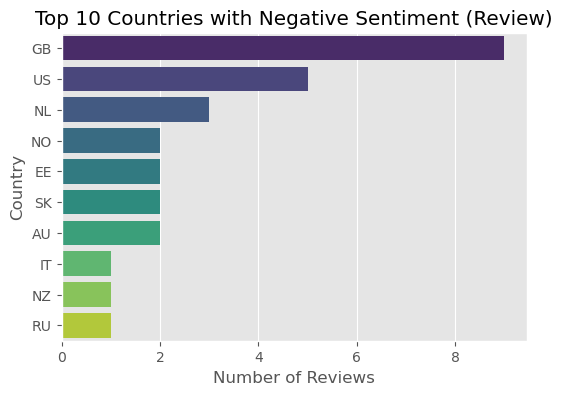

In [33]:
# Top 10 countries with Negative sentiment in 'vader_sentiment'

top_negative_countries_vader = get_top_countries_by_sentiment(data, 'vader_sentiment', 'negative')
print("\nTop 10 countries with Negative sentiment (VADER):")
print(top_negative_countries_vader)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_negative_countries_vader.values, y=top_negative_countries_vader.index, palette='viridis')
plt.title('Top 10 Countries with Negative Sentiment (VADER)')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.show()

# Top 10 countries with Negative sentiment in 'review_sentiment'

top_negative_countries_review = get_top_countries_by_sentiment(data, 'vader_review_sentiment', 'negative')
print("\nTop 10 countries with Negative sentiment (Review):")
print(top_negative_countries_review)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_negative_countries_review.values, y=top_negative_countries_review.index, palette='viridis')
plt.title('Top 10 Countries with Negative Sentiment (Review)')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.show()

In [34]:
# Count words frquency in the dataset
wf = data["clean_review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
wf.columns = ['words', 'wf']
wf_sorted = wf.sort_values(by='wf', ascending=False)
wf_sorted

,words,wf
39,aliexpress,8406.0
260,item,6535.0
94,seller,6413.0
165,refund,4935.0
24,order,4615.0
...,...,...
10976,fraudstersmy,1.0
10977,arrivedalis,1.0
10979,exemplory,1.0
10980,hngaroring,1.0


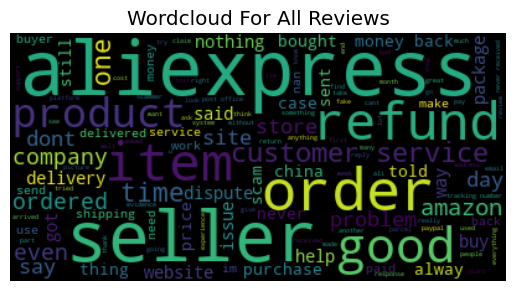

In [35]:
# Create and visualize a Word Cloud- To display the frequently occurring words in the dataset in a visual format
text = " ".join(i for i in data.clean_review)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud For All Reviews')
plt.axis("off")
plt.show()

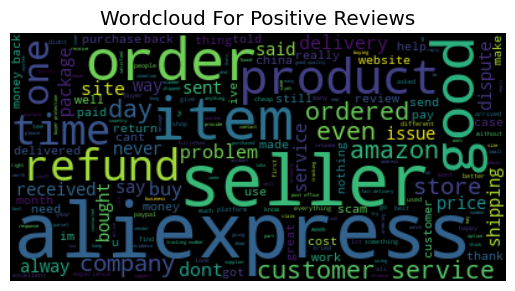

In [36]:
# Display the frequently occurring words in the positive reviews
positive_reviews_text = ' '.join(positive_reviews)

wordcloud = WordCloud().generate(positive_reviews_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud For Positive Reviews')
plt.axis("off")
plt.show()

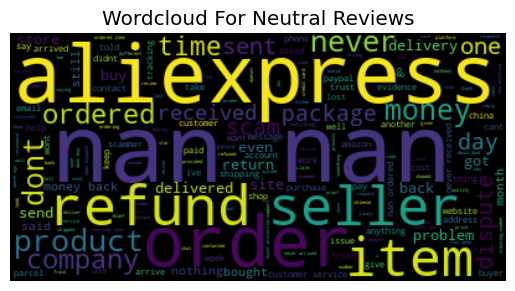

In [37]:
# Display the frequently occurring words in the negative reviews
neutral_reviews_text = ' '.join(neutral_reviews)

wordcloud = WordCloud().generate(neutral_reviews_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud For Neutral Reviews')
plt.axis("off")
plt.show()

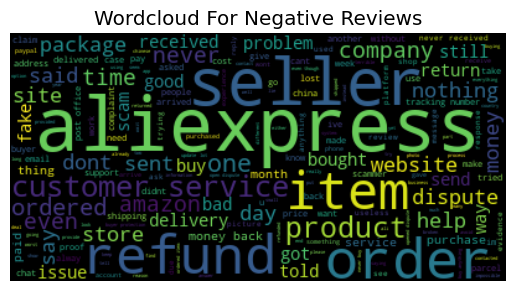

In [38]:
# Display the frequently occurring words in the negative reviews
negative_reviews_text = ' '.join(negative_reviews)

wordcloud = WordCloud().generate(negative_reviews_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud For Negative Reviews')
plt.axis("off")
plt.show()

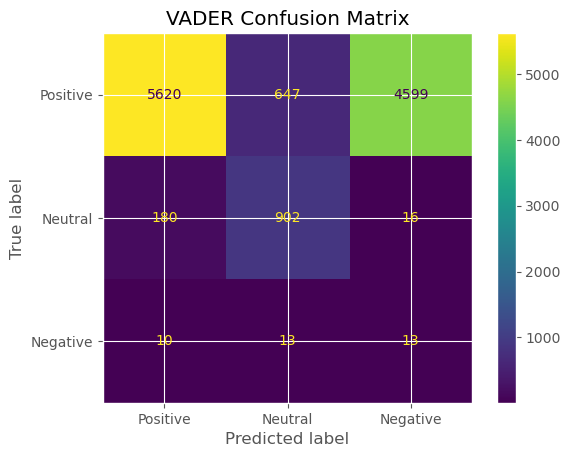

In [39]:
# Plot VADER confusion matrix
ConfusionMatrixDisplay(confusion_matrix=vader_confusion, display_labels=['Positive', 'Neutral', 'Negative']).plot()
plt.title('VADER Confusion Matrix')
plt.show()

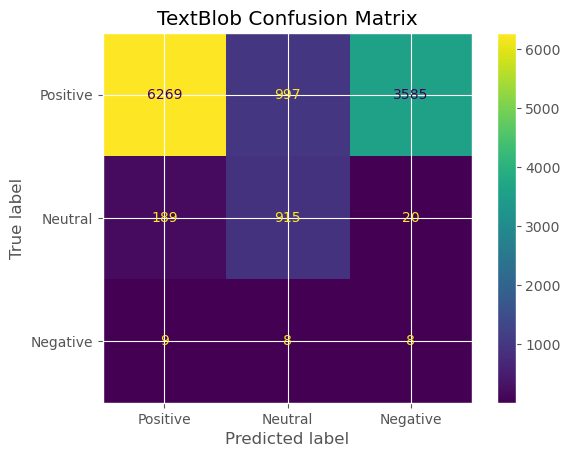

In [40]:
# Plot TextBlob confusion matrix
ConfusionMatrixDisplay(confusion_matrix=textblob_confusion, display_labels=['Positive', 'Neutral', 'Negative']).plot()
plt.title('TextBlob Confusion Matrix')
plt.show()

Correlation matrix:
                         StarRatings  vader_sentiment_numeric
StarRatings                 1.000000                 0.523082
vader_sentiment_numeric     0.523082                 1.000000


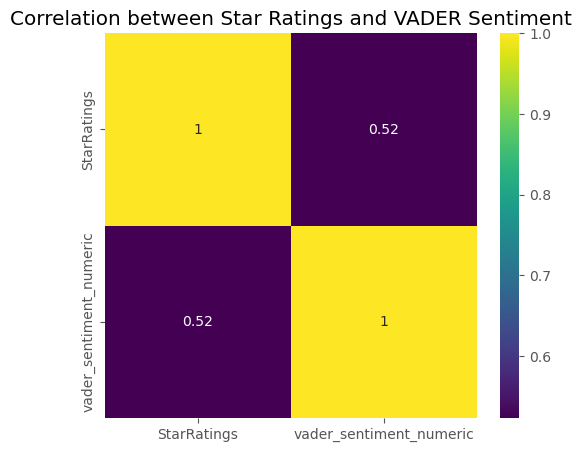

In [41]:
# Check for correlation between StarRatings and VADER Sentiment

# Convert 'vader_sentiment' to numerical values
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
data['vader_sentiment_numeric'] = data['vader_sentiment'].map(sentiment_mapping)

# Check for correlation
correlation = data[['StarRatings', 'vader_sentiment_numeric']].corr()

print("Correlation matrix:")
print(correlation)

# Plotting the correlation heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation, annot=True, cmap='viridis')
plt.title('Correlation between Star Ratings and VADER Sentiment')
plt.show()

Correlation matrix:
                            StarRatings  textblob_sentiment_numeric
StarRatings                     1.00000                     0.44954
textblob_sentiment_numeric      0.44954                     1.00000


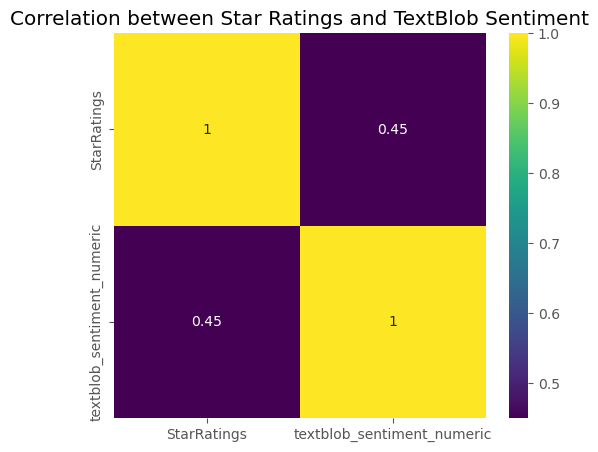

In [42]:
# Check for correlation between StarRatings and TextBlob Sentiment

# Convert 'vader_sentiment' to numerical values
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
data['textblob_sentiment_numeric'] = data['textblob_sentiment'].map(sentiment_mapping)

# Check for correlation
correlation = data[['StarRatings', 'textblob_sentiment_numeric']].corr()

print("Correlation matrix:")
print(correlation)

# Plotting the correlation heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation, annot=True, cmap='viridis')
plt.title('Correlation between Star Ratings and TextBlob Sentiment')
plt.show()

### 6. FEATURE ENGINEERING

In [44]:
# Create Bag of Words using CountVectorizer
cv = CountVectorizer()
dtm = cv.fit_transform(data['clean_review'])
dtm_data = pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names_out())

In [45]:
# TF-IDF
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(data['clean_review']).toarray()

In [46]:
# Extract target variable
y = data['vader_review_sentiment']

# Check the shape and type
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

Shape of x: (12000, 19833)
Shape of y: (12000,)


### 7. Handling Class Imbalance Using SMOTE

In [48]:
# Use SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

# Check class distribution after resampling
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())


Class distribution after SMOTE:
vader_review_sentiment
positive    10866
neutral     10866
negative    10866
Name: count, dtype: int64


### 8. Train-Test Split (with Stratification)

In [50]:
# Split data into training and test sets using stratification
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

print(f"x train: {x_train.shape}")
print(f"x test: {x_test.shape}")
print(f"y train: {y_train.shape}")
print(f"y test: {y_test.shape}")


x train: (26078, 19833)
x test: (6520, 19833)
y train: (26078,)
y test: (6520,)


### 9. Model Training & Evaluation (Naive Bayes, Logistic Regression, Random Forest)

Naive Bayes Results:
Accuracy: 0.9769938650306749
F1 Score: 0.9768814761637312
Precision: 0.9777584271052638
Recall: 0.9769938650306749


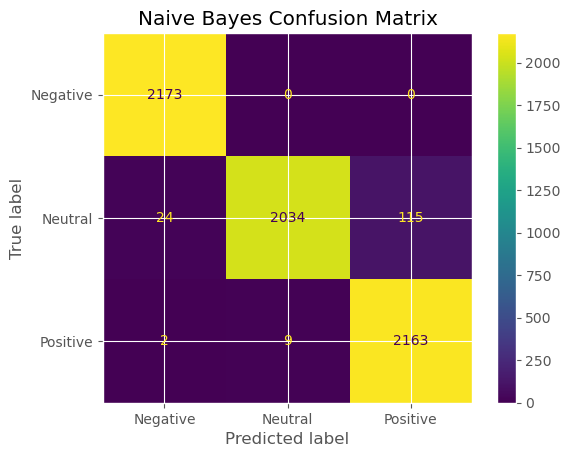

Logistic Regression Results:
Accuracy: 0.9966257668711657
F1 Score: 0.9966240397272093
Precision: 0.9966375834620624
Recall: 0.9966257668711657


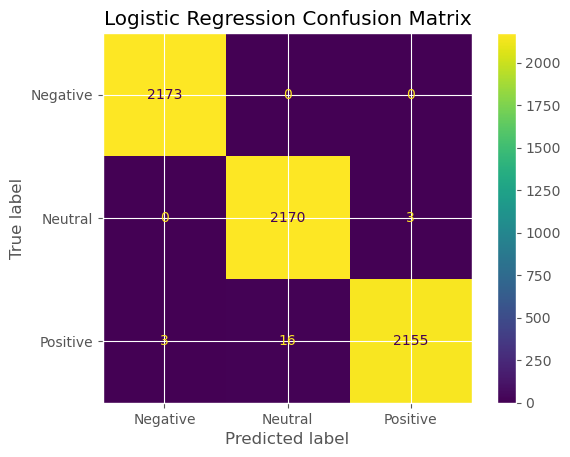

Random Forest Results:
Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


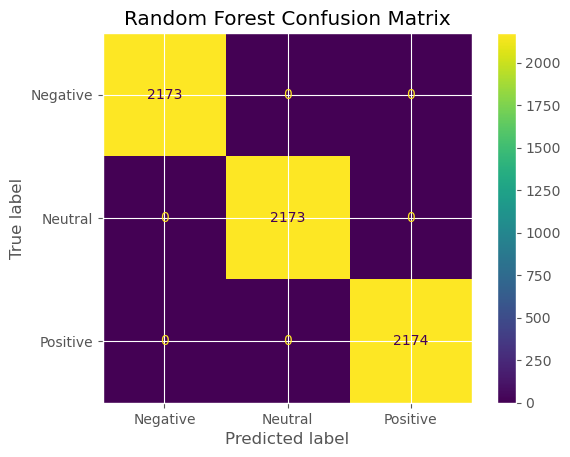

In [52]:
# Function to train model and print metrics
def evaluate_model(model, x_test, y_test, model_name):
    # Predict on the test set
    y_pred = model.predict(x_test)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # Print model results
    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive']).plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)
evaluate_model(nb_model, x_test, y_test, 'Naive Bayes')

# Train Logistic Regression Model
lg_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lg_model.fit(x_train, y_train)
evaluate_model(lg_model, x_test, y_test, 'Logistic Regression')

# Train Random Forest Model
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(x_train, y_train)
evaluate_model(rf_model, x_test, y_test, 'Random Forest')


### 10. HYPERPARAMETER TUNING

In [54]:
logreg = LogisticRegression(solver='liblinear')

# Reduce the parameter grid
param_dist_logreg = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [100]
}

# Use RandomizedSearchCV for a faster search
random_search_logreg = RandomizedSearchCV(logreg, param_distributions=param_dist_logreg, 
                                          n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_logreg.fit(x_train, y_train)

# Get the best estimator and accuracy
best_logreg_model = random_search_logreg.best_estimator_
print("Best Hyperparameters:", random_search_logreg.best_params_)
print(f"Accuracy: {best_logreg_model.score(x_test, y_test)}")


Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 10}
Accuracy: 0.9986196319018404


### 11. CONFUSION MATRIX AFTER TUNING FOR LOGISTICS REGRESSION

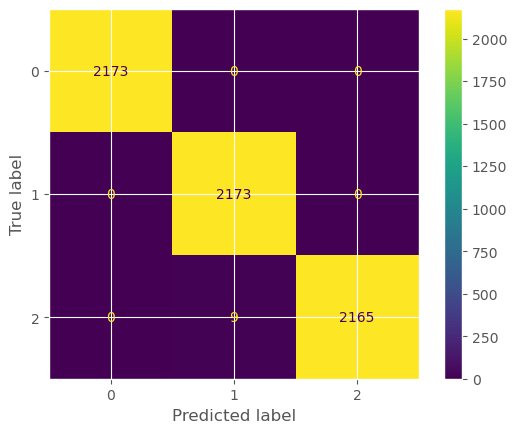

In [56]:
# Predict on the test set
y_pred = best_logreg_model.predict(x_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


### 12. CLASSIFICATION REPORTS

In [58]:
# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00      2173
     neutral       1.00      1.00      1.00      2173
    positive       1.00      1.00      1.00      2174

    accuracy                           1.00      6520
   macro avg       1.00      1.00      1.00      6520
weighted avg       1.00      1.00      1.00      6520



### 13. CROSS-VALIDATION FOR LOGISTIC REGRESSION, NAIVE BAYES AND RANDOM FOREST

In [60]:
# Perform cross-validation for logistic regression
cv_scores_lg = cross_val_score(lg_model, x_resampled, y_resampled, cv=5)
print(f"Cross-validation scores for Logistic Regression: {cv_scores_lg}")
print(f"Mean cross-validation score: {cv_scores_lg.mean()}")

# Perform cross-validation for Naive Bayes
cv_scores_nb = cross_val_score(nb_model, x_resampled, y_resampled, cv=5)
print(f"Cross-validation scores for Naive Bayes: {cv_scores_nb}")
print(f"Mean cross-validation score: {cv_scores_nb.mean()}")

# Perform cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, x_resampled, y_resampled, cv=5)
print(f"Cross-validation scores for Random Forest: {cv_scores_rf}")
print(f"Mean cross-validation score: {cv_scores_rf.mean()}")

Cross-validation scores for Logistic Regression: [0.99723926 0.99647239 0.99662577 0.99769903 0.99754564]
Mean cross-validation score: 0.9971164185481418
Cross-validation scores for Naive Bayes: [0.97269939 0.97960123 0.97638037 0.97407578 0.97361559]
Mean cross-validation score: 0.9752744690602364
Cross-validation scores for Random Forest: [0.99953988 0.99984663 1.         1.         1.        ]
Mean cross-validation score: 0.9998773006134968


### 13. SAVE MODELS

In [62]:
# Save the logistic regression model
with open('lg_model.pkl', 'wb') as file:
    pickle.dump(lg_model, file)

# Save the naive bayes model
with open('nb_model.pkl', 'wb') as file:
    pickle.dump(nb_model, file)

# Save the random forest model
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

# Save the best logistic regression model after hyperparameter tuning
with open('best_logreg_model.pkl', 'wb') as file:
    pickle.dump(best_logreg_model, file)

print("All models have been saved successfully!")


All models have been saved successfully!
